# **Authors**

***The work can be done in groups of up to 3 students. Please complete the following fields with your group number and list your names and HDI ID numbers.***

> **[HDU-AT3-25] Computer Vision**
>
> 1. Li Xin 22320404
> 2. Peng Yingrui 22320505

The task and guidelines were prepared by Andrei Zhdanov and Sergei Shavetov, ITMO University, 2025.

# **Practical Assignment No 1. Image Segmentation**

***Study of the basic methods for image segmentation into semantic areas.***

To implement the current practical assignment task we would need OpenCV and NumPy libraries along with image display functions we wrote during the Image Processing class. We import OpenCV's `cv2` library as `cv` for easier use.

In [3]:
# Import OpenCV library both as cv and cv2
import cv2
import cv2 as cv
# Import NumPy library as np
import numpy as np
# Import sys for floats epsilon value
import sys
# Import scikit-image for an entropy filter
import skimage.filters.rank
import skimage.morphology
# Import functions from our utility library
from pa_utils import ShowImages, exit

# **Introduction**

In the current practical assignment we will learn some basic segmentation methods. These will be various image intensity thresholding methods and color segmentation methods.

# **Task 1. Binarization**

***Take an arbitrary image. Perform the image binarization using the considered methods. Depending on the image, use upper or lower threshold binarization.***

The simplest way to segment an image into two classes (background and object pixels) is by *binarization*. In this case we will convert our image to black-and-white color model by applying threshold to a image pixel intensity values. There are several common approached how it can be done, so let's check them out.

The general image binarization algorithm would be as follows:

1. Load an image.
2. Convert it to grayscale.
3. Threshold the grayscale image.

## **1.1 Simple Thresholding**

We will try the thresholding algorithms on the classic Lena image. Let's read it in BGR and then convert to a GRAYSCALE mode. 

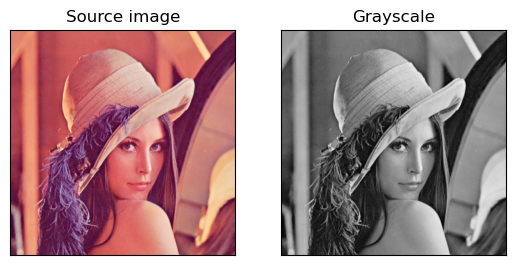

In [4]:
# Read an image from a file in BGR
fn = "images/lena_color.png"
I1 = cv.imread(fn, cv.IMREAD_COLOR)
if not isinstance(I1, np.ndarray) or I1.data == None:
  print("Error reading file \"{}\"".format(fn))
  exit()

# Convert loaded BGR image to grayscale
I1gray = cv.cvtColor(I1, cv.COLOR_BGR2GRAY)
# Display it
ShowImages([("Source image", I1), 
            ("Grayscale", I1gray)], 2)

### 1.1.1 Single thresholding

The first and the most simple binarization method is the single thresholding method which is described with the following formula:

$$
I_{st}(x,y) = 
\begin{cases}
	0 & \textit{if } I(x,y) \leqslant t,  \\
	1 & \textit{if } I(x,y)> t,
\end{cases}
$$

where 
- $I$ is the source image;
- $I_{st}$ is the single threshold binarized image;
- $t$ is the binarization threshold.


In OpenCV, the  thresholding operation is executed with `cv2.threshold(image, t, maxval, method)` function. It takes an `image` to process, the threshold parameter `t`, the value to set for thresholded image pixels `maxval`, and the thresholding `method` as its parameters. It returns a tuple with the threshold used during thresholding and the thresholded image.

The following single thresholding methods are supported in OpenCV:
- `cv2.THRESH_BINARY` - set everything greater than $t$ value to the $maxval$ and everything else to $0$:
$$
I_{binary}(x,y) = 
\begin{cases}
  0 & \textit{if } I(x,y) \leqslant t,  \\
  maxval &  \textit{if } I(x,y)> t,
\end{cases}
$$
- `cv2.THRESH_BINARY_INV` - set everything greater than $t$ value to the $0$ and everything else to $maxval$:
$$
I_{binary\_inv}(x,y) = 
\begin{cases}
  maxval & \textit{if } I(x,y) \leqslant t,  \\
  0 &  \textit{if } I(x,y)> t,
\end{cases}
$$
- `cv2.THRESH_TRUNC` - truncate everything greater than $t$ to $maxval$ while keeping other intact:
$$
I_{trunc}(x,y) = 
\begin{cases}
  I(x,y) & \textit{if } I(x,y) \leqslant t,  \\
  maxval &  \textit{if } I(x,y)> t,
\end{cases}
$$
- `cv2.THRESH_TOZERO` - threshold everything less or equal than $t$ to $0$ while keeping other intact:
$$
I_{tozero}(x,y) = 
\begin{cases}
  0 & \textit{if } I(x,y) \leqslant t,  \\
  I(x,y) &  \textit{if } I(x,y)> t,
\end{cases}
$$
- `cv2.THRESH_TOZERO_INV` - threshold everything grater then $t$ to $0$ while keeping other intact:
$$
I_{tozero}(x,y) = 
\begin{cases}
  I(x,y) & \textit{if } I(x,y) \leqslant t,  \\
  0 &  \textit{if } I(x,y)> t,
\end{cases}
$$

Simple threshold binarization according to the formula above is executed by using the `cv2.THRESH_BINARY`  method.

Let's try executing the single thresholding with a threshold value of $127$ to segment every pixel above the threshold to $1$ and every pixel below the threshold to $0$.

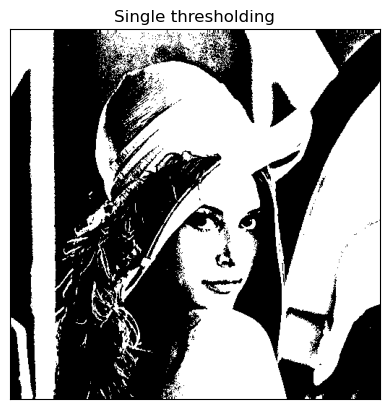

In [5]:
# Single thresholding
t = 127
ret, I1st = cv.threshold(I1gray, t, 1, cv.THRESH_BINARY)
ShowImages([("Single thresholding", I1st)])

By varying the thresholding parameter `t` we can shift the binarization boundary.

### 1.1.2 Double Thresholding

In some cases, the single thresholding is not enough, for example, if we need to select a region. In this case, the double (range) thresholding is used. The double thresholding method is described with the following formula:

$$
	I_{dt}(x,y) = 
	\begin{cases}
		0, I(x,y) \leqslant t_1,  \\
		1, t_1 < I(x,y) \leqslant t_2,  \\
		0, I(x,y) > t_2,
	\end{cases}
$$

where 
- $I$ is the source image;
- $I_{dt}$ is the double threshold binarized image;
- $t_1$ is the lower binarization threshold;
- $t_2$ is the upper binarization threshold.

OpenCV does not provide a special function for double thresholding, however, it can be done by the subsequent call of two threshold functions with different methods:
1. At first, should set all values above $t_2$ to zeros while keeping other intact (`THRESH_TOZERO_INV` method);
2. Secondly, should set all values below $t_1$ to zeros (`THRESH_BINARY` method).

Let's try executing the double thresholding with $(127, 200)$ range to segment every pixel within this range to $1$ and every pixel outside of this range to $0$.

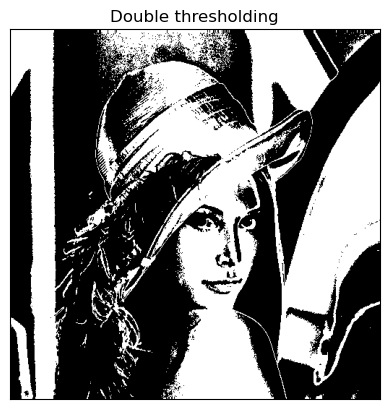

In [6]:
# Double thresholding
t1 = 127
t2 = 200
ret, I1dt = cv.threshold(I1gray, t2, 1, cv.THRESH_TOZERO_INV)
ret, I1dt = cv.threshold(I1dt, t1, 1, cv.THRESH_BINARY)
ShowImages([("Double thresholding", I1dt)])

By varying the thresholding parameters `t1` and `t2` we can shift the binarization range borders.

### **1.1.3 Self-work**

> ***Self-work***
>
> Take some arbitrary image and threshold it with **single and double** thresholding methods. Display the results.

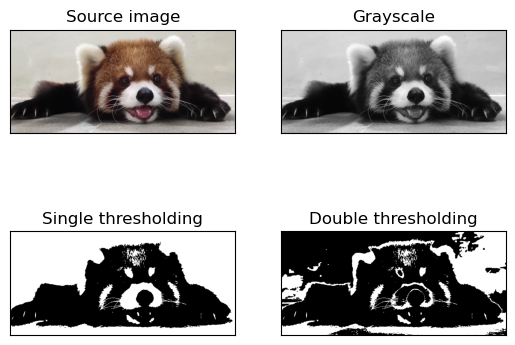

In [7]:
# TODO Place your solution here
# Read an image from a file in BGR
fn = "images/1.png"
i1 = cv.imread(fn, cv.IMREAD_COLOR)
if not isinstance(i1, np.ndarray) or i1.data == None:
  print("Error reading file \"{}\"".format(fn))
  exit()

# Convert loaded BGR image to grayscale
i1gray = cv.cvtColor(i1, cv.COLOR_BGR2GRAY)

# Single thresholding
t = 127
ret, i1st = cv.threshold(i1gray, t, 1, cv.THRESH_BINARY)

# Double thresholding
t1 = 127
t2 = 200
ret, i1dt = cv.threshold(i1gray, t2, 1, cv.THRESH_TOZERO_INV)
ret, i1dt = cv.threshold(i1dt, t1, 1, cv.THRESH_BINARY)

ShowImages([("Source image", i1), 
            ("Grayscale", i1gray),
            ("Single thresholding", i1st),
            ("Double thresholding", i1dt)], 2)

## **1.2 Automatic Thresholding**

Binarization thresholds $t$, $t_1$, and $t_2$ can either be set manually or calculated using special algorithms. In the case of automatic threshold calculation, the following algorithms can be used.

### 1.2.1 Mean value

1. Find the maximum $I_{max}$ and minimum $I_{min}$ intensity values of the original grayscale image and find their arithmetic mean. The arithmetic mean will be the global binarization threshold $t$:

$$
  t = \dfrac{I_{max}-I_{min}}{2}.
$$

### 1.2.2 Intensity gradient weighting

Find the optimal threshold $t$ based on the modulus of each pixel intensity gradient. For this, at first, it is required to calculate the modulus of the gradient at each image point $(x,y)$:

$$
	G(x,y) = \max \left\{|I(x+1, y)-I(x-1, y)|, \\|I(x,y+1)-I(x,y-1)| \right\},
$$

then calculate the optimal threshold value $t$:

$$
	t=\dfrac{\sum_{x=0}^{X-1} \sum_{y=0}^{Y-1} I(x,y)G(x,y)}{\sum_{x=0}^{X-1} \sum_{y=0}^{Y-1} G(x,y)}.
$$

### 1.2.3 Otsu method

The optimal threshold $t$ can be calculated by the statistical Otsu method [1] which splits all pixels into two classes $1$ and $2$. This method minimizes the variance within each class $\sigma_1^2(t)$ and $\sigma_2^2(t)$ and maximizes the variance between classes.

The algorithm for calculating the threshold by the Otsu method consists of the following steps:

1. Compute an image histogram of intensities, and probabilities $p_i=\dfrac{n_i}{N}$ for each intensity level, where $n_i$ is the number of pixels with intensity level $i$, and $N$ is the number of pixels in the image.
2. Set the initial threshold $t=0$ and threshold $k \in (0, L)$, which divides all pixels into two classes, where $L$ is the maximum value of the image intensity.
3. In the loop for each value of threshold from $k=1$ to $k=L-1$:
    1. Compute probabilities of two classes $\omega_j(0)$, and arithmetic mean $\mu_j(0)$, where $j=\overline{1,2}$:

    $$
    \omega_1(k)=\sum_{s=0}^{k}p_s,
    $$
    $$
    \omega_2(k)=\sum_{s=k+1}^{L}p_s=1-\omega_1(k),
    $$
    $$
			\mu_1(k)=\sum_{s=0}^{k} \dfrac{s \cdot p_s}{\omega_1},
    $$
    $$
			\mu_2(k)=\sum_{s=k+1}^{L} \dfrac{s \cdot p_s}{\omega_2}.
    $$
	  2. Calculate the interclass variance $\sigma_b^2(k)$:
    $$
    \sigma_b^2(k)=\omega_1(k)\omega_2(k)(\mu_1(k)-\mu_2(k))^2.
    $$
	  3. If the calculated value $\sigma_b^2(k)$ is greater than the current value $t$, then assign the value of the interclass variance to the threshold $t=\sigma_b^2(k)$.
4. The optimal threshold $t$ corresponds to the maximum $\sigma_b^2(k)$.

### References
1. Otsu, N. (1979). A threshold selection method from gray-level histograms. IEEE Transactions on Systems, Man, and Cybernetics, 9 (1), 62–66. https://doi.org/10.1109/TSMC.1979.4310076

In OpenCV thresholding with the threshold calculated by the Otsu method is executed with the same `cv2.threshold(...)` function. To use the Otsu threshold method you have to use the `THRESH_OTSU` parameter as a thresholding method. This function can be used to calculate the Otsu threshold without thresholding an image as well, for this we have to run it in a dry run mode:

```python
tr, ret = cv2.threshold(I, 0, 1, cv2.THRESH_OTSU + cv2.THRESH_DRYRUN)
print("The Otsu threshold value is {}".format(tr))
```

Let's try executing the thresholding with the threshold calculated by the Otsu method.

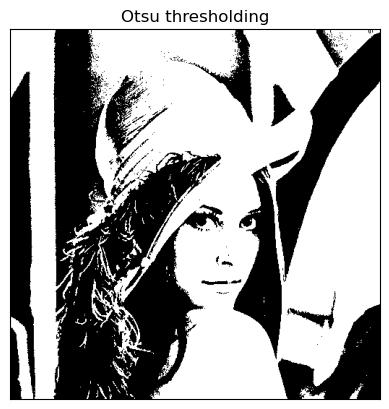

In [8]:
# Otsu thresholding
tr, I1otsu = cv.threshold(I1gray, 0, 1, cv.THRESH_OTSU)
ShowImages([("Otsu thresholding", I1otsu)])

### 1.2.4 Adaptive thresholding

Adaptive methods do not work with the entire image, but only with its fragments. Such approaches are often used when working with images that represent non-uniformly illuminated objects.

In OpenCV adaptive thresholding  is performed with the `cv2.adaptiveThreshold(image, maxval, algorithm, method, blockSize, c)` function. It supports two adaptive thresholding algorithms:
- `ADAPTIVE_THRESH_MEAN_C` uses simple rectangular kernel mean;
- `ADAPTIVE_THRESH_GAUSSIAN_C` uses a kernel with Gauss weights. 

These algorithms support two thresholding methods:
- `cv2.THRESH_BINARY` to set everything greater than the threshold value to the $maxval$ and everything else to $0$;
- `cv2.THRESH_BINARY_INV` to set everything greater than the threshold value to the $0$ and everything else to $maxval$.

Kernel size is defined by the `blockSize` parameter, and the parameter value `c` is subtracted from the mean value calculated within a window.

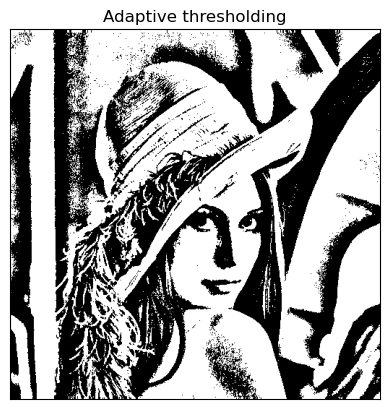

In [9]:
I1ta = cv.adaptiveThreshold(I1gray, 255, cv.ADAPTIVE_THRESH_GAUSSIAN_C, cv.THRESH_BINARY, 121, 5)
ShowImages([("Adaptive thresholding", I1ta)])

### **1.2.5 Self-work**

> ***Self-work***
>
> Take some arbitrary image and threshold it with **four listed** automatic threshold calculation method:
> - Mean value threshold
> - Intensity gradient weighted threshold
> - Otsu threshold
> - Adaptive threshold
>
> Display the resulting images.
>
> ***Notes:***
> 1. *To calculate the mean value fast you should use existing NumPy functions.*
> 2. *To make gradient calculation faster you may consider using the `cv2.copyMakeBorder(image, 1, 1, 1, 1, cv2.BORDER_REPLICATE)` function to create a copy of an image with 1 pixel border that replicates the border pixel value to extension region. Then you can use this image with a 1-pixel border to calculate gradients fast with NumPy functions.*

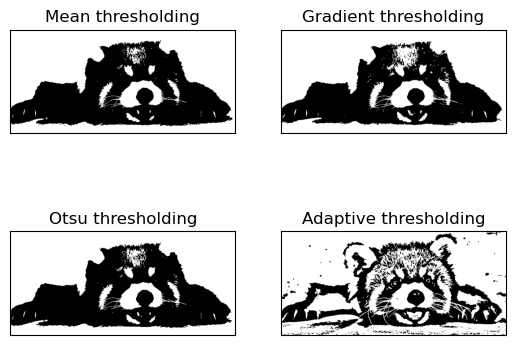

In [10]:
# TODO Place your solution here

t = (i1gray.astype(np.float64).max() + i1gray.astype(np.float64).min()) / 2
ret, i1mean = cv2.threshold(i1gray, t, 1, cv2.THRESH_BINARY)

i1padded = cv2.copyMakeBorder(i1gray, 1, 1, 1, 1, cv2.BORDER_REPLICATE)

dx, dy = np.gradient(i1padded)
G = np.maximum(np.abs(dx), np.abs(dy))

t = np.sum(i1padded * G) / np.sum(G)

ret, i1gradient = cv2.threshold(i1gray, t, 1, cv2.THRESH_BINARY)

ret, i1otsu = cv2.threshold(i1gray, 0, 1, cv2.THRESH_OTSU)

i1ta = cv2.adaptiveThreshold(i1gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 121, 5)

ShowImages([("Mean thresholding", i1mean),
            ("Gradient thresholding", i1gradient),
            ("Otsu thresholding", i1otsu),
            ("Adaptive thresholding", i1ta)], 2)

# **Task 2. Color Segmentation**

***Take an arbitrary image containing the face(s). Perform the image segmentation according to the Weber principle. Perform the image segmentation based on the skin color and try different formulas on photos with various photo illumination conditions.***

Let's consider several basic methods of image segmentation.

## **2.1 Weber principle**

The *Weber principle* tells us that there is a not noticeable distance for the human eye and depending on the intensity value, this range can be calculated using the formula:

$$
	W(I) = 
	\begin{cases}
		20-\dfrac{12I}{88} & \textit{if } 0 \leqslant I \leqslant 88,  \\
		0,002(I-88)^2 & \textit{if } 88 < I \leqslant 138,  \\
		\dfrac{7(I-138)}{117}+13 & \textit{if } 138 < I \leqslant 255.
	\end{cases}
$$

 So, the *Weber principle* assumes that the human eye does not perceive well the difference in gray levels between $I(n)$ and $I(n)+W(I(n))$, where $W(I(n))$ is the Weber function, $n$ is the class number, $I$ is the piecewise non-linear grayscale function. Based on this principle the segmentation algorithm is designed for the segmentation of grayscale images.

The Webber principle segmentation algorithm consists of the following steps:

1. Initializate initial conditions: first class number $n=1$, all image pixels are not segmented.
2. Find the minimum value of the not-segmented image part and store it to $I(n)$.
3. Calculate the $W(I(n))$ value according to the Weber formula and assign the segment $n$ and the value $I(n)$ to all pixels whose intensities are in the range $[I(n),I(n)+W(I(n))]$.
4. If there are any not-segmented pixels in the image, then increment $n$ ($n=n+1$) and go to step 2. 
5. If there are no not segmented pixels then the segmentation is finished.

The segmentation data can be displayed with artificial colors and a JET color scheme:

```python
Ijet = cv.applyColorMap(((I - I.min()).astype(np.float32) * 255 / 
                         (I.max() - I.min())).astype(np.uint8), cv.COLORMAP_JET)
```

### **2.1.1 Self-work**

> ***Self-work***
>
> Implement the image segmentation algorithm based on the Weber principle. Display the resulting images.

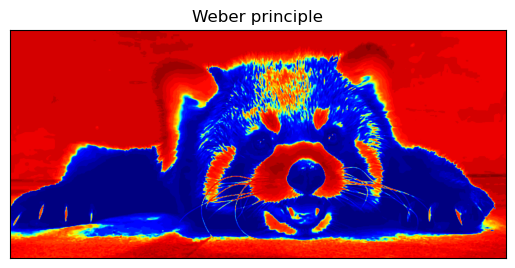

In [11]:
def weber_segmentation(i1gray):
    n = 1
    segmented = np.zeros_like(i1gray, dtype=np.uint8)

    while True:
        unsegmented = i1gray[segmented == 0]
        if not unsegmented.size:
            break
        I_n = np.min(unsegmented)

        if 0 <= I_n <= 88:
            W_n = 20 - 12.0 * I_n / 88.0
        elif 88 < I_n <= 138:
            W_n = 0.002 * (I_n - 88.0) ** 2
        else:
            W_n = 7.0 * (I_n - 138.0) / 117.0 + 13.0

        W_n = np.clip(W_n, 0, 20)

        segmented[np.logical_and(i1gray >= I_n, i1gray <= I_n + W_n)] = n
        n += 1

    return segmented

segmented = weber_segmentation(i1gray)

i1jet = cv2.applyColorMap(((segmented - segmented.min()).astype(np.float32) * 255 / 
                         (segmented.max() - segmented.min())).astype(np.uint8), cv2.COLORMAP_JET)

ShowImages([("Weber principle", i1jet)])

## **2.2 Skin Color Segmentation**

The general principle of skin color segmentation is determining the criterion for the proximity of the pixel intensity to the skin tone. It is quite difficult to describe the *skin tone* analytically since its description is based on the human perception of color. Moreover, it changes with lighting, differs among different nationalities, etc.

There are several analytical descriptions for images in the RGB color space that allow a pixel to be assigned to the *skin* class of the following conditions. For example, at uniform daylight illumination, the following conditions may be used to segment a part of an image as skin:
$$
	\begin{cases}
		R > 95, \\
		G > 40, \\
		B > 20, \\
		\max\{R,G,B\}-\min\{R,G,B\} > 15, \\
		|R-G| > 15, \\
		R > G, \\
		R > B,
	\end{cases}
$$

In the case of the flashlight or daylight lateral illumination:

$$
	\begin{cases}
		R > 220, \\
		G > 210, \\
		B > 170, \\
		|R-G| \leqslant 15, \\
		G > B, \\
		R > B,
	\end{cases}
$$

Also, there is a formula that is based on normalized RGB values ($r, g, b$ which are normalized by the sum of $R, G, B$):

$$
	\begin{cases}
		r=\frac{R}{R+G+B}, \\
		g=\frac{G}{R+G+B}, \\
		b=\frac{B}{R+G+B}, \\
		\frac{r}{g}>1,185, \\
		\frac{rb}{(r+g+b)^2}>0,107, \\
		\frac{rg}{(r+g+b)^2}>0,112.
	\end{cases}
$$

To implement these segmentation methods with OpenCV we should use NumPy matrix operations and create a mask to segment skin. Let us implement the skin color segmentation for the first of these three formulas.

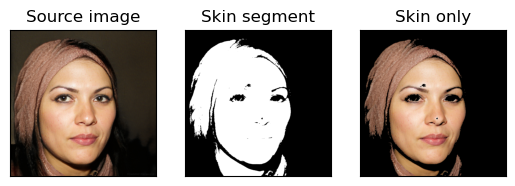

In [12]:
# We will load a random image with a face on it
# (image source: https://thispersondoesnotexist.com/)
import requests

url = "https://thispersondoesnotexist.com/"
try:
  response = requests.get(url)
  I2 = cv.imdecode(np.asarray(bytearray(response.content), dtype = np.uint8), cv.IMREAD_COLOR)
  if not isinstance(I2, np.ndarray) or I2.data == None:
    print("Error loading URL \"{}\"".format(url))
except BaseException:
  # If something got wrong then load a local failsafe file
  print("Something went wrong while loading URL \"{}\"".format(url))
  print("Loading a local failsafe file...")

  fn = "images/people.jpg"
  I2 = cv.imread(fn, cv.IMREAD_COLOR)
  if not isinstance(I2, np.ndarray) or I2.data == None:
    print("Error reading file \"{}\"".format(fn))
    exit()

# Split into layers
I2BGR = cv.split(I2)

# Build up the mask
I2skin = np.logical_and.reduce(
          [I2BGR[2] > 95, # R > 95
            I2BGR[1] > 40, # G > 40
            I2BGR[0] > 20, # B > 20
            np.maximum.reduce(I2BGR) - np.minimum.reduce(I2BGR) > 15, # Max(R,G,B) - Min(R,G,B) > 15
            np.abs(I2BGR[2] - I2BGR[1]) > 15, # |R - G| > 15
            I2BGR[2] > I2BGR[0],              # R > B
            I2BGR[2] > I2BGR[1]])             # G > B

# Create a copy of the source image and remove everything except for the face from it
I2copy = I2.copy()
I2copy[~I2skin] = 0

# Display the result
ShowImages([("Source image", I2), 
            ("Skin segment", I2skin),
            ("Skin only", I2copy)], 3)

### **2.2.1 Self-work**

> ***Self-work***
>
> Implement the **two** remaining skin segmentation algorithms. Display the resulting images.
>
> ***Notes.***
> 1. *Formula 2 works well only for direct flashlight illumination, so it would segment nothing on most of the regular images. You may use "images/flashlight.jpg" image to check your result.*

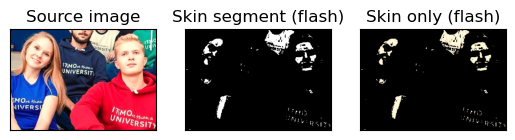

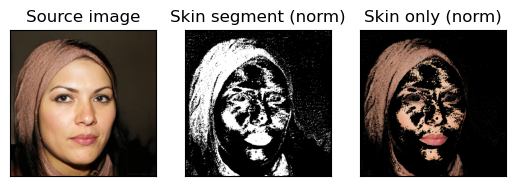

In [13]:
fn = "images/flashlight.jpg"
I2flash = cv.imread(fn, cv.IMREAD_COLOR)
I2flashBGR = cv.split(I2flash)

I2skin_flash = np.logical_and.reduce([
    I2flashBGR[2] > 220,
    I2flashBGR[1] > 210,
    I2flashBGR[0] > 170,
    np.abs(I2flashBGR[2] - I2flashBGR[1]) <= 15,
    I2flashBGR[1] > I2flashBGR[0],
    I2flashBGR[2] > I2flashBGR[0]
])

I2copy_flash = I2flash.copy()
I2copy_flash[~I2skin_flash] = 0

ShowImages([("Source image", I2flash),
            ("Skin segment (flash)", I2skin_flash),
            ("Skin only (flash)", I2copy_flash)], 3)

I2BGR = cv.split(I2)
r = I2BGR[2] / (I2BGR[2] + I2BGR[1] + I2BGR[0] + 1e-6)
g = I2BGR[1] / (I2BGR[2] + I2BGR[1] + I2BGR[0] + 1e-6)
b = I2BGR[0] / (I2BGR[2] + I2BGR[1] + I2BGR[0] + 1e-6)

I2skin_norm = np.logical_and.reduce([
    r / (g + 1e-6) > 1.185,
    r * b / ((r + g + b) ** 2 + 1e-6) > 0.107,
    r * g / ((r + g + b) ** 2 + 1e-6) > 0.112
])

I2copy_norm = I2.copy()
I2copy_norm[~I2skin_norm] = 0

ShowImages([("Source image", I2),
            ("Skin segment (norm)", I2skin_norm),
            ("Skin only (norm)", I2copy_norm)], 3)

# **Task 3. Chromatic Segmentation**

***Take an arbitrary image containing a limited number of colored objects. Perform image segmentation in the uniform color space by the nearest neighbors method. Perform image segmentation in the CIE Lab color space by the $k$-means method .***

In the CIE Lab color space, the value of lightness is separated from the value of the chromatic components of the color (hue, saturation). The lightness of a color is given by the $L$ coordinate, which can range from $0$ (dark) to $100$ (light). The chromatic component of a color is given by two Cartesian coordinates $a$ (which defines the color position in the range from *green* $(-128)$ to *red* $(127)$) and $b$ (which defines the color position in the range from *blue* $(-128)$ to *yellow* $(127)$). In CIE Lab color space the grayscale colored pixels of an image have zero $a$ and $b$ coordinates. We can use the CIE Lab color space to perform the segmentation of an image based only on chromatic color components and ignore lightness.

## **3.1 Segmentation in CIE Lab color space**

The algorithm's general idea is to divide a color image into segments of dominant colors. For this, we will let the user select a set of dominant colors, then search for a distance to each of these colors and segment image pixels by the shortest distance.

At first, we have to let the user select points on the image. To do it we will use the OpenCV GUI library and create a window with the mouse callback function `MouseHandler()`. This function will register each left mouse button click and add corresponding pixel coordinates to an array with selected points. This will continue until the window is shown or the user presses an ESC button.

So, the general workflow is as follows:
1. Create a GUI window with `cv2.imhow(window_name, I)` function.
2. Register a mouse callback with `cv2.setMouseCallback(window_name, MouseHandler, params)`. 
3. Run the infinite loop and break it in case if:
    - Window is closed (checked by `cv2.getWindowProperty(window_name, cv2.WND_PROP_VISIBLE) < 1`);
    - Or the ESC button is pressed (checked by `cv.waitKey(100) == 27`).

In the mouse handler (`MouseHandler()`) function we check the event type, append click coordinates to the selected points list, and update the shown image by making a new image and calling  `cv2.imhow(window_name, I)` function again.

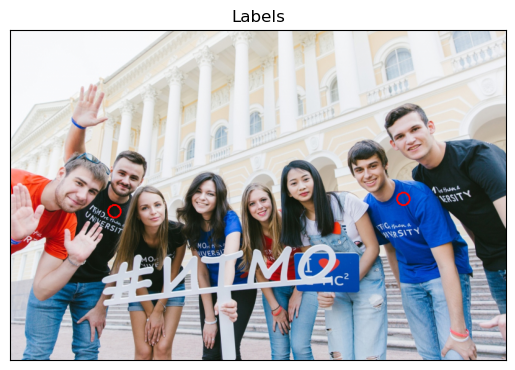

In [21]:
# Read an image from file
fn = "images/people.jpg"
I3 = cv.imread(fn, cv.IMREAD_COLOR)
if not isinstance(I3, np.ndarray) or I3.data == None:
  print("Error reading file \"{}\"".format(fn))
  exit()

# Set window name and other parameters
window_name = "Select points"
points = []
radius = 10

# Define the mouse handler
def MouseHandler(event, x, y, flags, param):
  # Only the left button click event is processed
  # All others are ignored
  if event != cv.EVENT_LBUTTONDOWN:
    return
  # Append new point coordinates
  points.append((x, y))
  # Create a new image 
  I3copy = I3.copy()
  # And draw circles for each registered mouse click
  for p in points:
    cv.circle(I3copy, p, radius, (0, 0, 255), 2)
  # Then update the image shown in the window
  cv.imshow(window_name, I3copy)

# Create a window, show it, and register the callback
cv.namedWindow(window_name)
cv.imshow(window_name, I3)
cv.setMouseCallback(window_name, MouseHandler)

# Wait for an ESC key press or window is closed
while True:
  if cv.waitKey(100) == 27:
    break
  if cv.getWindowProperty(window_name, cv.WND_PROP_VISIBLE) < 1:
    break

# Destroy all windows data
cv.destroyAllWindows()

# Draw circles for each registered mouse click
I3copy = I3.copy()
for p in points:
  cv.circle(I3copy, p, radius, (0, 0, 255), 2)
# And display it
ShowImages([("Labels", I3copy)])

Now that we have the list of the selected points we may proceed with the general segmentation algorithm:
1. Convert an image to CIE Lab color space.
2. Take an area around selected pixels and calculate the mean value in this area to get the reference $ab$ color for each segment.
3. Calculate the Euclidean distance in $ab$ layers ($d = \sqrt{(a_2 - a_1)^2 + (b_2 - b_1)^2})$ for each image pixel from the selected points.
4. For each image pixel select the nearest color in $ab$ coordinate space. This will be the desired segmentation.

In [22]:
# 1. Convert to CIE Lab
I3lab = cv.cvtColor(I3, cv.COLOR_BGR2LAB)
# Split it into layers
I3lab = cv.split(I3lab)

In [23]:
# 2. Instead of taking the selected pixel value
# We will calculate the mean color value in an area around the pixel
points_ab = []
points_bgr = []
for p in points:
  mask = np.zeros_like(I3lab[0])
  cv.circle(mask, p, radius, 255, -1)
  a = I3lab[1].mean(where = mask > 0)
  b = I3lab[2].mean(where = mask > 0)
  points_ab.append((a, b))
  points_bgr.append(I3[mask > 0, :].mean(axis=(0)))

In [24]:
# 3. Calculate distance
distances = []
for ab in points_ab:
  distances.append(np.sqrt(
    np.power(I3lab[1] - ab[0], 2) + 
    np.power(I3lab[2] - ab[1], 2)))
  
# Calculate the minimum distance among them all
distance_min = np.minimum.reduce(distances)

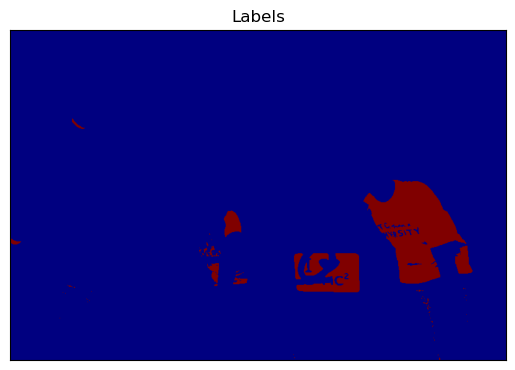

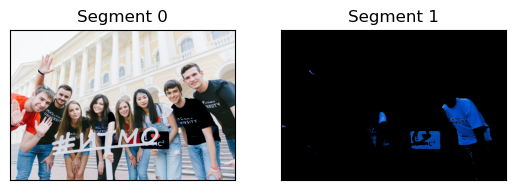

In [25]:
# 4. Create segmented areas
I3labels = np.zeros_like(I3lab[0], dtype = np.uint8)

I3segments = []
# Fill them for each selected color
for i in range(len(points_ab)):
  Itmp = np.zeros_like(I3)
  # Segmentation mask is created by finding all pixels with a matching distance
  mask = distance_min == distances[i]
  # Add labels to the segmentation plot
  I3labels[mask] = i
  # Segmented area of source image
  Itmp[mask] = I3[mask]
  # Add the segmented area to a list of segments
  I3segments.append(("Segment {}".format(i), Itmp))

# Display it
ShowImages([("Labels", cv.applyColorMap(((I3labels - I3labels.min()).astype(np.float32)  * 255 / 
                                         (I3labels.max() - I3labels.min())).astype(np.uint8), cv.COLORMAP_JET))])
ShowImages(I3segments, 2)

Finally, we can place the distribution of image pixel colors to a plot in the $(a, b)$ coordinate system. The plot pixel color is defined by a mean $BGR$ which was calculated along with calculating the mean $ab$ value and stored in the `points_bgr` array. 

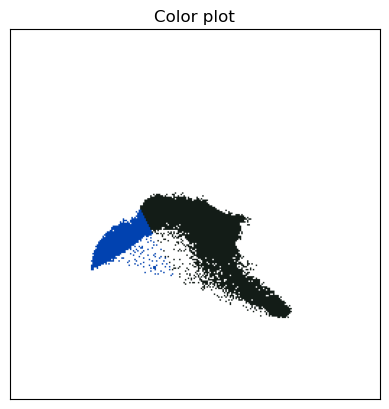

In [26]:
# The color distribution plot
I3plot = np.full((256, 256, 3), 255, dtype = np.uint8)
for i in range(len(points_ab)):
  mask = I3labels == i
  I3plot[I3lab[1][mask], I3lab[2][mask], :] = points_bgr[i]

# Display it
ShowImages([("Color plot", I3plot)])

### **3.1.1 Self-work**

> ***Self-work***
> 
> Try modifying the above algorithm to use the HSV color model.
>
> ***Notes.***
> 1. To convert from BGR to HSV color space you should use the `cv2.COLOR_RGB2HSV` color model conversion parameter.

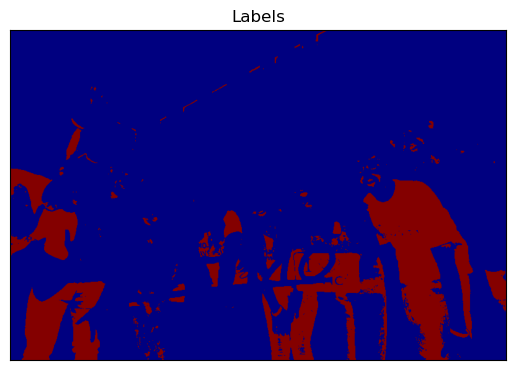

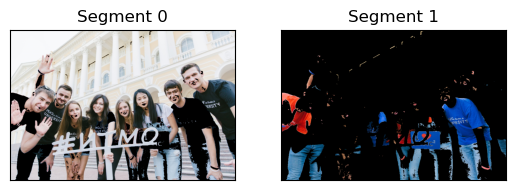

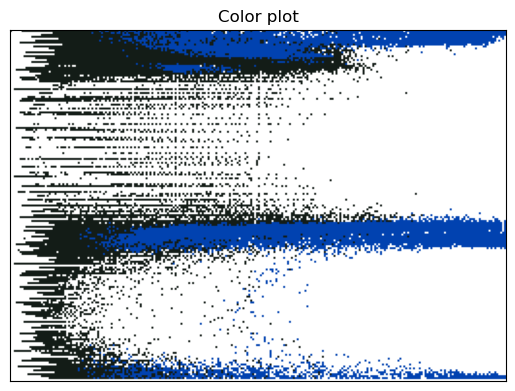

In [27]:
I3hsv = cv.cvtColor(I3, cv.COLOR_BGR2HSV)
I3h, I3s, I3v = cv.split(I3hsv)

points_hsv = []
points_bgr = []
for p in points:
    mask = np.zeros_like(I3h)
    cv.circle(mask, p, radius, 255, -1)

    h = I3h.mean(where=mask > 0)
    s = I3s.mean(where=mask > 0)
    v = I3v.mean(where=mask > 0)
    points_hsv.append((h, s, v))

    points_bgr.append(I3[mask > 0, :].mean(axis=0))

def hsv_distance(hsv1, h, s, v):
    dh = np.minimum(np.abs(hsv1[0] - h), 180 - np.abs(hsv1[0] - h))
    ds = hsv1[1] - s
    dv = hsv1[2] - v
    return np.sqrt(dh ** 2 + ds ** 2 + dv ** 2)

distances = []
for hsv in points_hsv:
    hsv_stack = (I3h, I3s, I3v)
    dist = hsv_distance(hsv_stack, hsv[0], hsv[1], hsv[2])
    distances.append(dist)

distance_min = np.minimum.reduce(distances)

I3labels = np.zeros_like(I3h, dtype=np.uint8)
I3segments = []

for i in range(len(points_hsv)):
    Itmp = np.zeros_like(I3)
    mask = distance_min == distances[i]
    I3labels[mask] = i
    Itmp[mask] = I3[mask]
    I3segments.append((f"Segment {i}", Itmp))

ShowImages([("Labels", cv.applyColorMap(((I3labels - I3labels.min()).astype(np.float32) * 255 /
                                         (I3labels.max() - I3labels.min() + 1e-6)).astype(np.uint8), cv.COLORMAP_JET))])

ShowImages(I3segments, 2)

I3plot = np.full((181, 256, 3), 255, dtype=np.uint8)
for i in range(len(points_hsv)):
    mask = I3labels == i
    I3plot[I3h[mask], I3s[mask], :] = points_bgr[i]

ShowImages([("Color plot", I3plot)])

## **3.2 $k$-means Clustering**

The idea of the method is to determine the centers of $k$-clusters and assign to each cluster the pixels closest to these centers. All pixels are considered as vectors $x_i, i=\overline{1,p}$. The segmentation algorithm consists of the following steps:
1. Randomly determine $k$ vectors $m_j, j=\overline{1,k}$, which are declared as initial centers of clusters.
2. Update mean values of the vectors $m_j$ by calculating distances from each vector $x_i$ to each $m_j$ and their classification according to the criterion of minimal distance from the vector to the cluster, recalculation of average values $m_j$ across all clusters.
3. Repeat step $2$ until the cluster centers stop changing.

The implementation of the method is very similar to the previous approach and contains a number of similar actions. We will work in the CIE Lab color space, so the first step is transformation from the BGR space to the Lab and splitting into layers:

```python
Ilab = cv2.cvtColor(I, cv2.COLOR_BGR2LAB)
Ilab = cv2.split(Ilab)
```

Then we have to merge $a$ and $b$ layers of the Lab representation of our source image and use the NumPy reshaping function to create the two-dimensional array of the image pixel colors:

```python
ab = cv2.merge([Ilab[1], Ilab[2]])
ab = ab.reshape(-1, 2).astype(np.float32)
```

This two-dimensional array can be then passed to the `cv2.kmeans()` function that performs the $k$-means clustering. Parameters allow us to define stop criteria and the number of attempts to select a set of starting points. In the following code stop criteria is defined as not more than 10 iterations of difference between steps less than 1. Starting points are selected randomly (due to the `cv2.KMEANS_RANDOM_CENTERS` flag being used) and selection is done 10 times. After algorithm execution is finished, the returned `labels` parameter is reshaped back to an original image shape:

```python
k = 3
criteria = (cv2.TERM_CRITERIA_EPS + cv.TERM_CRITERIA_MAX_ITER, 10, 1.0)
ret, labels, centers = cv2.kmeans(ab, k, None, criteria, 10, cv2.KMEANS_RANDOM_CENTERS)
labels = labels.reshape((Ilab[0].shape))
```

Then, it is possible to use the generated labels to segment the image into a set of images or masks:

```python
segmentedFrames = []
for i in range(k):
  Itmp = np.zeros_like(I)
  mask = labels == i
  Itmp[mask] = I[mask, :]
  segmentedFrames.append(Itmp)
```

### **3.2.1 Self-work**

> ***Self-work***
> 
> Implement the $k$-means clustering algorithm and display the result.

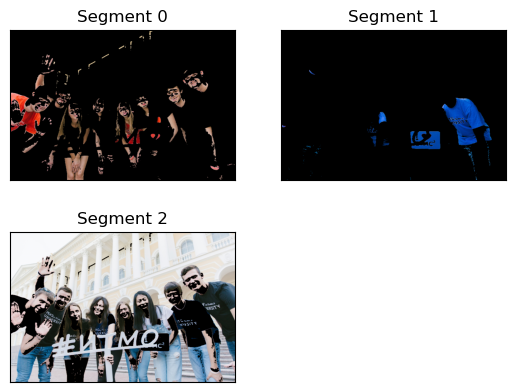

In [28]:
Ilab = cv.cvtColor(I3, cv.COLOR_BGR2LAB)
Ilab_split = cv.split(Ilab)

ab = cv2.merge([Ilab_split[1], Ilab_split[2]])
ab = ab.reshape(-1, 2).astype(np.float32)

k = 3
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0)
ret, labels, centers = cv2.kmeans(ab, k, None, criteria, 10, cv2.KMEANS_RANDOM_CENTERS)

labels = labels.reshape((Ilab.shape[0], Ilab.shape[1]))

segmentedFrames = []
for i in range(k):
    Itmp = np.zeros_like(I3)
    mask = labels == i
    Itmp[mask] = I3[mask]
    segmentedFrames.append(("Segment {}".format(i), Itmp))

ShowImages(segmentedFrames, 2)

# **Task 4. Texture Segmentation**

***Take an arbitrary image containing two heterogeneous textures. Perform texture segmentation of the image.***

In texture segmentation, three main approaches are used to describe texture: statistical, structural, and spectral. In the practical assignment, we will consider a statistical approach that describes the segment texture as smooth, rough, or grainy. 

We will consider the image intensity $I$ as a random variable $z$, which corresponds to the distribution probability $p(z)$ calculated from the image histogram. The *Central moment* of order $n$ of a random variable $z$ is the parameter $\mu_n(z)$ calculated by the formula:

$$
	\mu_n(z)=\sum_{i=0}^{L-1}(z_i-m)^n p(z_i),
$$

where 
- $L$ is the number of intensity levels;
- $m$ is the mean value of a random variable $z$:

$$
	m=\sum_{i=0}^{L-1} z_i p(z_i).
$$

The expression above implies that $\mu_0=1$ and $\mu_1=0$. To describe the texture, the *variance* of a random variable is important, which is equal to the second moment $\sigma^2(z)=\mu_2(z)$ and is a measure of the brightness contrast. It can be used to calculate the features of *smoothness*. 

So, let us introduce a measure of relative smoothness $R$:

$$
	R=1-\dfrac{1}{1+\sigma^2(z)},
$$

The relative smoothness is zero for areas with constant intensity (zero variance) and approaches unity for large variances $\sigma^2(z)$. For grayscale images with an intensity range $[0, 255]$, it is necessary to normalize the variance to the range $[0, 1]$, since the values of the variances will be too large for the initial range. Normalization is carried out by dividing the variance $\sigma^2(z)$ by $(L-1)^2$.

The *standard deviation* is also often used as a texture characteristic:

$$
	s=\sigma(z).
$$

The third moment is the *histogram symmetry characteristic*. To estimate texture features, the *entropy* $E$ function is used, which determines the spread of neighboring pixels intensities:

$$
	E=-\sum_{i=0}^{L-1} p(z_i) \log_2{p(z_i)}.
$$

Another important characteristic that describes the texture is the *uniformity measure* $U$, which evaluates the uniformity of the histogram:

$$
	U=\sum_{i=0}^{L-1} p^2(z_i).
$$

Let us try doing segmentation using *Entropy* of a pixel neighborhood as a texture characteristic. For this we have to calculate the image Entropy first, then threshold it to get the starting morphology. Unfortunately, OpenCV does not provide the corresponding function for Entropy calculation, however, in the case of Python it can be found in the scikit-image library named `skimage.filters.rank.entropy()`. To define the neighboring area we will use the rectangular $9\times9$ kernel created by `skimage.morphology.square()` function. Since scikit-image converts an image to `float64` type we have to do a backward conversion along with normalization to a $[0, 1]$ range.

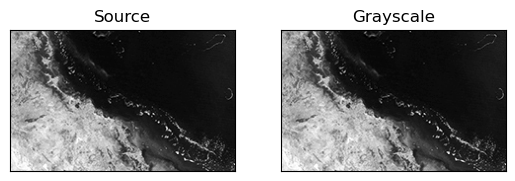

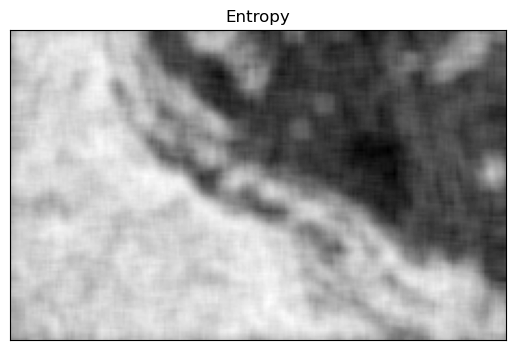

In [29]:
# Read an image from file
fn = "images/texture.jpg"
I4 = cv.imread(fn, cv.IMREAD_COLOR)
if not isinstance(I4, np.ndarray) or I4.data == None:
  print("Error reading file \"{}\"".format(fn))
  exit()

# Convert to grayscale
I4gray = cv.cvtColor(I4, cv.COLOR_BGR2GRAY)
# And display
ShowImages([("Source", I4), ("Grayscale", I4gray)], 2)

# Calculate entropy
I4e = skimage.filters.rank.entropy(I4gray, skimage.morphology.square(9)).astype(np.float32)
# Normalize it to [0, 1] range
I4en = (I4e - I4e.min()) / (I4e.max() - I4e.min())
# And display
ShowImages([("Entropy", I4en)], 2)

Next, we have to threshold the entropy image and filter the resulting morphology. For thresholding, we will use the Otsu thresholding, while the morphological filtering will be performed in three steps: 
1. At first, remove connected regions (equivalent to MATLAB's `bwareaopen()`  function);
2. Secondly, remove internal defects with closing operation (executed by `cv2.morphologyEx()` function with `cv2.MORPH_CLOSE` parameter) and rectangular structure element of size $9\times9$ (created by `cv2.getStructuringElement()` function with shape parameter  `cv2.MORPH_RECT`);
3. And, thirdly, fill remaining *holes* (equivalent to MATLAB's `imfill('holes')`  function).

Even if OpenCV lacks MATLAB's `bwareaopen(A, dim)` and `imfill(I, 'holes')` functions, they can be easily implemented using OpenCV's `connectedComponentsWithStats()`. You may check the `pa_utils.py` file for the implementation of these functions with OpenCV. However, now we will simply import and use them.

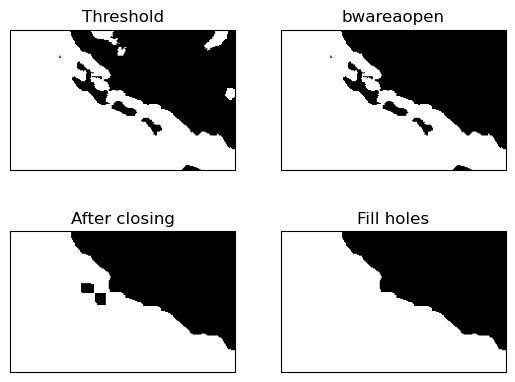

In [30]:
from pa_utils import bwareaopen, imfillholes

# Threshold
ret, I4t = cv.threshold(np.uint8(I4en * 255), 0, 255, cv.THRESH_OTSU)

# Remove connected regions
I4bwao = bwareaopen(I4t, 2000)
# Remove internal defects with closing
nhood = cv.getStructuringElement(cv.MORPH_RECT, (9, 9))
I4close = cv.morphologyEx(I4bwao, cv.MORPH_CLOSE, nhood)
# Fill holes to get the final mask
I4mask = imfillholes(I4close)

ShowImages([("Threshold", I4t), ("bwareaopen", I4bwao), ("After closing", I4close), ("Fill holes", I4mask)], 2)

Next, using the OpenCV `cv2.findContours()` function it's possible to find shape contours and then draw them on a black background with the `cv2.drawContours()` function to define the contour mask. Then we can use this mask to apply the border to the source image.

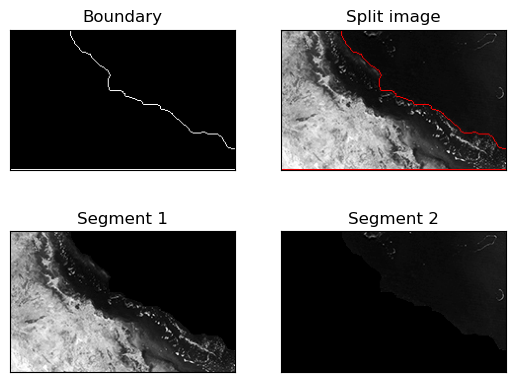

In [31]:
# Find boundary
contours, h = cv.findContours(I4mask, cv.RETR_TREE, cv.CHAIN_APPROX_NONE)
I4boundary = np.zeros_like(I4mask)
cv.drawContours(I4boundary, contours, -1, 255, 1)
# Outline the whole image as well
cv.rectangle(I4boundary, (0, 0), (I4.shape[1] - 1, I4.shape[0] - 1), 255)

# Separate segments
I4seg1 = I4.copy()
I4seg1[I4mask == 0] = 0
I4seg2 = I4.copy()
I4seg2[I4mask != 0] = 0
I4split = I4.copy()
I4split[I4boundary != 0] = [0, 0, 255]

ShowImages([("Boundary", I4boundary), 
            ("Split image", I4split),
            ("Segment 1", I4seg1),
            ("Segment 2", I4seg2)], 2)

### **4.1 Self-work**

> ***Self-work***
> 
> Take an arbitrary image and implement the image texture segmentation. Display the results.
>
> ***Optional***
>
> Use another statistical texture parameter instead of Entropy when implementing the texture segmentation.

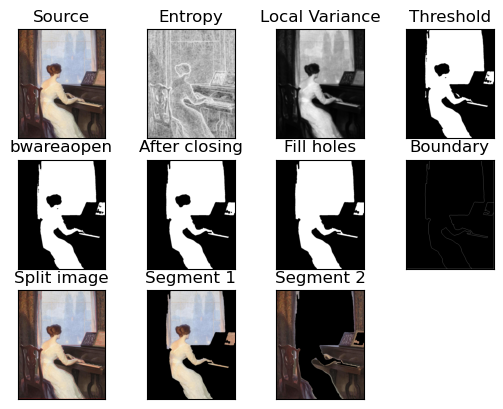

In [ ]:
# Read an image from file
fn = "images/peaceful.jpg"
i4 = cv.imread(fn, cv.IMREAD_COLOR)
if not isinstance(i4, np.ndarray) or i4.data is None:
    print("Error reading file \"{}\"".format(fn))
    exit()

# Convert to grayscale
i4gray = cv.cvtColor(i4, cv.COLOR_BGR2GRAY)


# Calculate entropy
i4e = skimage.filters.rank.entropy(i4gray, skimage.morphology.square(9)).astype(np.float32)
# Normalize entropy to [0, 1]
i4en = (i4e - i4e.min()) / (i4e.max() - i4e.min())


# OPTIONAL TASK: Use local variance instead of entropy
# Calculate local mean
i4_mean = cv.boxFilter(i4gray, -1, (9, 9), normalize=True)
# Calculate local squared image
i4_sq = (i4gray.astype(np.float32)) ** 2
i4_mean_sq = cv.boxFilter(i4_sq, -1, (9, 9), normalize=True)
# Variance = E[X^2] - (E[X])^2
i4v = i4_mean_sq - i4_mean**2
# Normalize variance to [0, 1]
i4vn = (i4v - i4v.min()) / (i4v.max() - i4v.min())


# switch between entropy and variance:
# i4feature = i4en      # use entropy
i4feature = i4vn        # use local variance (optional task)


# Threshold using Otsu
ret, i4t = cv.threshold(np.uint8(i4feature * 255), 0, 255, cv.THRESH_OTSU)

# Remove small connected regions
i4bwao = bwareaopen(i4t, 2000)
# Closing to remove internal defects
nhood = cv.getStructuringElement(cv.MORPH_RECT, (9, 9))
i4close = cv.morphologyEx(i4bwao, cv.MORPH_CLOSE, nhood)
# Fill holes
i4mask = imfillholes(i4close)

# Find boundary
contours, h = cv.findContours(i4mask, cv.RETR_TREE, cv.CHAIN_APPROX_NONE)
i4boundary = np.zeros_like(i4mask)
cv.drawContours(i4boundary, contours, -1, 255, 1)
cv.rectangle(i4boundary, (0, 0), (i4.shape[1] - 1, i4.shape[0] - 1), 255)

# Separate segments
i4seg1 = i4.copy()
i4seg1[i4mask == 0] = 0
i4seg2 = i4.copy()
i4seg2[i4mask != 0] = 0
i4split = i4.copy()
i4split[i4boundary != 0] = [0, 0, 255]

# Show images
ShowImages([
    ("Source", i4),
    ("Entropy", i4en),
    ("Local Variance", i4vn),              # Optional task feature visualization
    ("Threshold", i4t),
    ("bwareaopen", i4bwao),
    ("After closing", i4close),
    ("Fill holes", i4mask),
    ("Boundary", i4boundary),
    ("Split image", i4split),
    ("Segment 1", i4seg1),
    ("Segment 2", i4seg2)
], 4)

# **Questions**

***Please answer the following questions:***

 - *When is it appropriate to use Weber segmentation?*
 > When the image has noticeable contrast.
 >
 >

 - *What are the $a$ and $b$ color coordinates values for a grayscale image in the CIE Lab color space?*
 > 0
 > 
 >

 - *What is the reason for performing an image segmentation in the CIE Lab color space instead of the original RGB one?*
 > Because in the CIE Lab color space, we can perform the segmentation of an image based only on chromatic color components and ignore lightness.
 >
 >

# **Conclusion**

***What have you learned with this task? Don't forget to conclude it.***

 > We have learned some basic segmentation methods with this task.
Binarization segments an image into two classes (background and object pixels).
Color segmentation separates an image based on color information, while chromatic segmentation operates on chromatic color components (a and b channels in the CIE Lab space), ignoring brightness.

 >In addition, we explored texture-based segmentation using statistical measures.First, we implemented segmentation based on entropy, which quantifies local randomness and highlights textured regions.
Then, as part of the optional task, we replaced entropy with local variance, a different statistical texture parameter that captures intensity variation in local neighborhoods.
 